## 1. Setup

In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

from seg_reg_net import SegRegNet
from utils.preprocessing.misc import gaussian_smoothing
from utils.visualization.vis import plot_seg_reg_maps

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 2. SegRegNet

In [4]:
INPUT_SHAPE = (768, 1024, 3)#(256, 256, 3)
model = SegRegNet(input_shape=INPUT_SHAPE, loss_weights=[0.3, 0.7])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 1024, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 1024, 32 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 384, 512, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 384, 512, 64) 18496       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

## Load an image with its GT

In [5]:
def desc_img(img, title=''):
    print(title, img.shape, img.dtype, (img.min(), img.max()), img.sum())

In [6]:
MULT_FACTOR = 2000.

img_path = '../datasets/toy_set/train/images/IMG_186.jpg'
dots_path = '../datasets/toy_set/train/gt_dots/IMG_186.png'
img = skimage.io.imread(img_path) / 255.
dots = (skimage.io.imread(dots_path) > 0).astype(np.uint8)
gt_seg_map = (gaussian_smoothing([dots.astype(np.float32)], sigma=10) > 2e-4)[..., np.newaxis]
gt_density_map = MULT_FACTOR * gaussian_smoothing([dots.astype(np.float64)], sigma=10)[..., np.newaxis]

desc_img(img,  'img:')
desc_img(dots, 'dots:')
desc_img(gt_seg_map, 'seg_map:')
desc_img(gt_density_map, 'reg_map:')

img: (768, 1024, 3) float64 (0.0, 1.0) 857299.6274509799
dots: (768, 1024) uint8 (0, 1) 208
seg_map: (1, 768, 1024, 1) bool (False, True) 137001
reg_map: (1, 768, 1024, 1) float64 (0.0, 24.741556960145125) 416000.0000000001


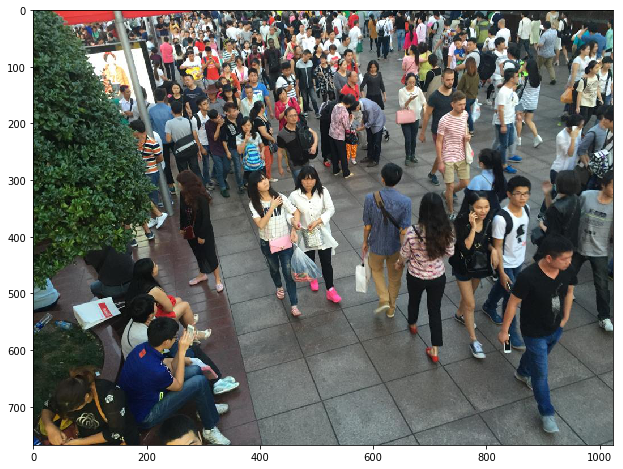

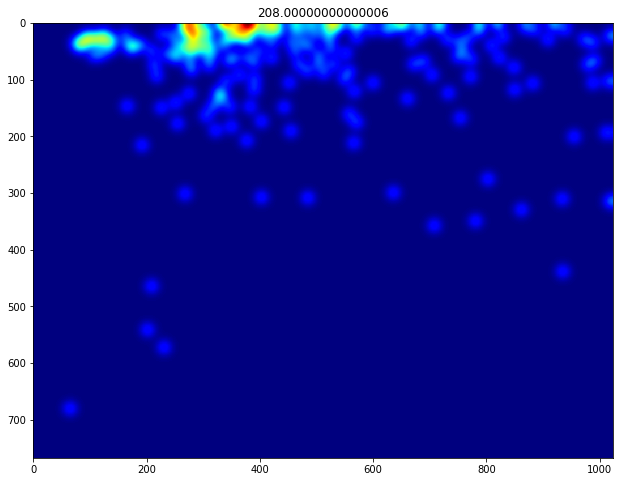

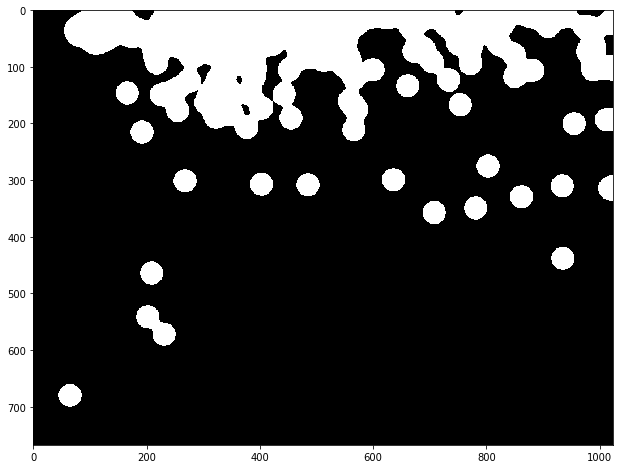

In [7]:
figsize=(16, 8)
plt.figure(figsize=figsize)
plt.imshow(img)
plt.figure(figsize=figsize)
plt.title(gt_density_map.sum()/MULT_FACTOR)
plt.imshow(gt_density_map.squeeze()/MULT_FACTOR, cmap='jet')
plt.figure(figsize=figsize)
plt.imshow(gt_seg_map.squeeze().astype(np.float32), cmap='gray')
plt.show()

## Predict

In [8]:
preds = model.predict(img[np.newaxis])
print(len(preds))

pred1 = preds[0]
pred2 = preds[1]

desc_img(pred1, 'pred1:')
desc_img(pred2, 'pred2:')

2
pred1: (1, 768, 1024, 1) float32 (0.22426943, 0.6572682) 372600.56
pred2: (1, 768, 1024, 1) float32 (-3.519482, -0.018970765) -1150988.8


## Plot

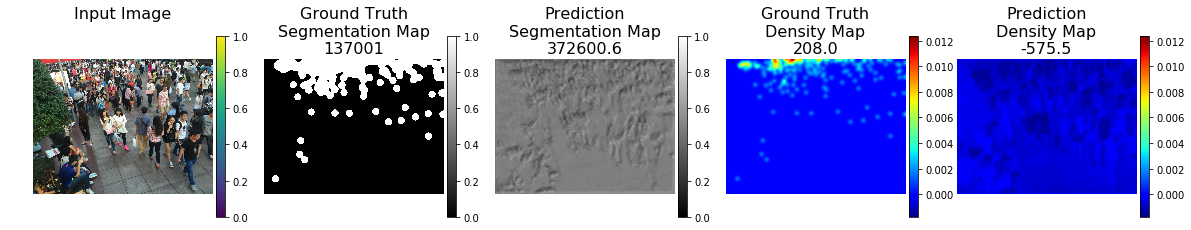

In [9]:
plot_seg_reg_maps(img, gt_seg_map, pred1, gt_density_map, pred2, MULT_FACTOR)

## Train the model on a single example (sanity check)

In [10]:
x = img[np.newaxis]
y = [gt_seg_map, gt_density_map]

Epoch 1/1
 - 5s - loss: 1.1731 - activation_1_loss: 0.6898 - conv2d_12_loss: 1.3802
Epoch 1/1
 - 1s - loss: 1.6134 - activation_1_loss: 1.0278 - conv2d_12_loss: 1.8644
Epoch 1/1
 - 1s - loss: 1.3769 - activation_1_loss: 0.7400 - conv2d_12_loss: 1.6499
Epoch 1/1
 - 1s - loss: 0.5508 - activation_1_loss: 0.5810 - conv2d_12_loss: 0.5379
Epoch 1/1
 - 1s - loss: 0.5083 - activation_1_loss: 0.5973 - conv2d_12_loss: 0.4702
Epoch 1/1
 - 1s - loss: 0.5028 - activation_1_loss: 0.5569 - conv2d_12_loss: 0.4796
Epoch 1/1
 - 1s - loss: 0.4648 - activation_1_loss: 0.5567 - conv2d_12_loss: 0.4254
Epoch 1/1
 - 1s - loss: 0.4468 - activation_1_loss: 0.5661 - conv2d_12_loss: 0.3957
Epoch 1/1
 - 1s - loss: 0.4767 - activation_1_loss: 0.5534 - conv2d_12_loss: 0.4438
Epoch 1/1
 - 1s - loss: 0.4403 - activation_1_loss: 0.5527 - conv2d_12_loss: 0.3922
Epoch 1/1
 - 1s - loss: 0.4395 - activation_1_loss: 0.5524 - conv2d_12_loss: 0.3911
Epoch 1/1
 - 1s - loss: 0.4515 - activation_1_loss: 0.5458 - conv2d_12_loss:

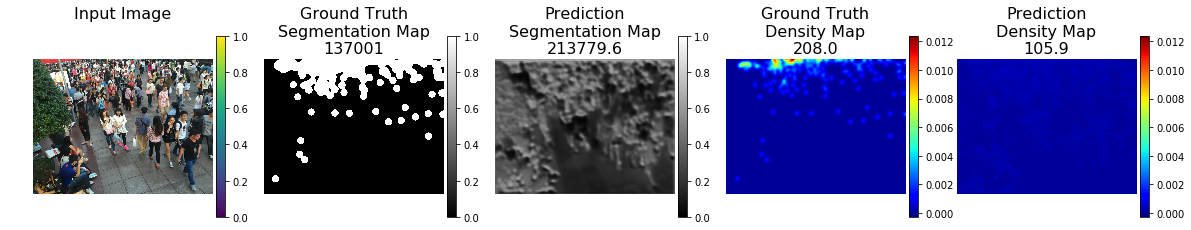

Epoch 1/1
 - 1s - loss: 0.3808 - activation_1_loss: 0.4242 - conv2d_12_loss: 0.3623
Epoch 1/1
 - 1s - loss: 0.3724 - activation_1_loss: 0.4041 - conv2d_12_loss: 0.3588
Epoch 1/1
 - 1s - loss: 0.3600 - activation_1_loss: 0.3660 - conv2d_12_loss: 0.3574
Epoch 1/1
 - 1s - loss: 0.3494 - activation_1_loss: 0.3461 - conv2d_12_loss: 0.3508
Epoch 1/1
 - 1s - loss: 0.3516 - activation_1_loss: 0.3602 - conv2d_12_loss: 0.3479
Epoch 1/1
 - 1s - loss: 0.3521 - activation_1_loss: 0.3790 - conv2d_12_loss: 0.3406
Epoch 1/1
 - 1s - loss: 0.3277 - activation_1_loss: 0.3037 - conv2d_12_loss: 0.3380
Epoch 1/1
 - 1s - loss: 0.3496 - activation_1_loss: 0.3790 - conv2d_12_loss: 0.3370
Epoch 1/1
 - 1s - loss: 0.3412 - activation_1_loss: 0.3181 - conv2d_12_loss: 0.3511
Epoch 1/1
 - 1s - loss: 0.3257 - activation_1_loss: 0.3014 - conv2d_12_loss: 0.3361
Epoch 1/1
 - 1s - loss: 0.3304 - activation_1_loss: 0.3103 - conv2d_12_loss: 0.3390
Epoch 1/1
 - 1s - loss: 0.3167 - activation_1_loss: 0.2815 - conv2d_12_loss:

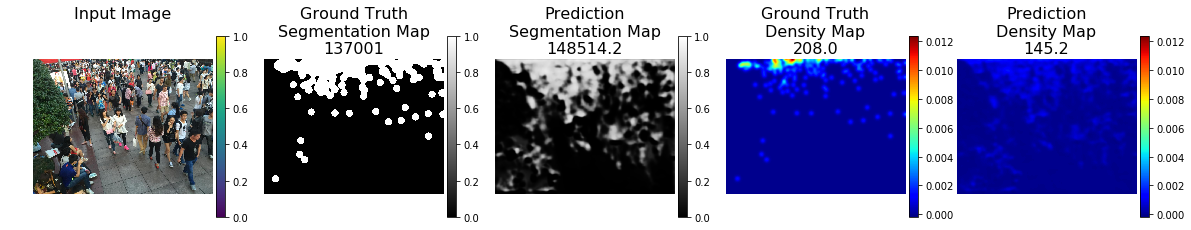

Epoch 1/1
 - 1s - loss: 0.2768 - activation_1_loss: 0.2393 - conv2d_12_loss: 0.2929
Epoch 1/1
 - 1s - loss: 0.2788 - activation_1_loss: 0.2431 - conv2d_12_loss: 0.2942
Epoch 1/1
 - 1s - loss: 0.2695 - activation_1_loss: 0.2399 - conv2d_12_loss: 0.2822
Epoch 1/1
 - 1s - loss: 0.2595 - activation_1_loss: 0.2271 - conv2d_12_loss: 0.2734
Epoch 1/1
 - 1s - loss: 0.2621 - activation_1_loss: 0.2350 - conv2d_12_loss: 0.2737
Epoch 1/1
 - 1s - loss: 0.2558 - activation_1_loss: 0.2264 - conv2d_12_loss: 0.2684
Epoch 1/1
 - 1s - loss: 0.2412 - activation_1_loss: 0.2189 - conv2d_12_loss: 0.2508
Epoch 1/1
 - 1s - loss: 0.2323 - activation_1_loss: 0.2102 - conv2d_12_loss: 0.2417
Epoch 1/1
 - 1s - loss: 0.2329 - activation_1_loss: 0.2182 - conv2d_12_loss: 0.2391
Epoch 1/1
 - 1s - loss: 0.2608 - activation_1_loss: 0.2316 - conv2d_12_loss: 0.2733
Epoch 1/1
 - 1s - loss: 0.3320 - activation_1_loss: 0.3471 - conv2d_12_loss: 0.3255
Epoch 1/1
 - 1s - loss: 0.2352 - activation_1_loss: 0.2062 - conv2d_12_loss:

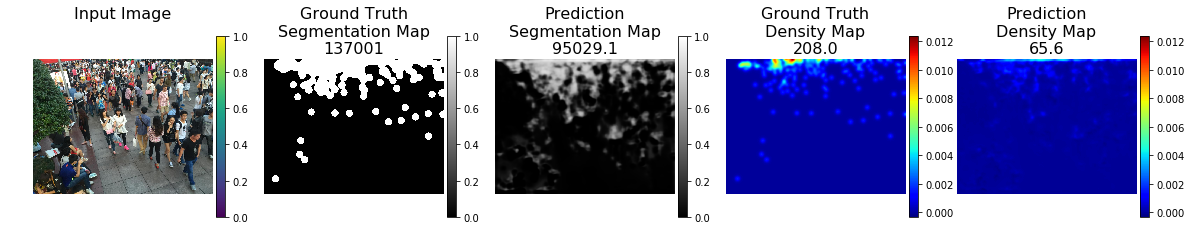

Epoch 1/1
 - 1s - loss: 0.2495 - activation_1_loss: 0.2275 - conv2d_12_loss: 0.2590
Epoch 1/1
 - 1s - loss: 0.2122 - activation_1_loss: 0.2078 - conv2d_12_loss: 0.2141
Epoch 1/1
 - 1s - loss: 0.2548 - activation_1_loss: 0.2225 - conv2d_12_loss: 0.2687
Epoch 1/1
 - 1s - loss: 0.2090 - activation_1_loss: 0.2050 - conv2d_12_loss: 0.2107
Epoch 1/1
 - 1s - loss: 0.2373 - activation_1_loss: 0.2373 - conv2d_12_loss: 0.2373
Epoch 1/1
 - 1s - loss: 0.2136 - activation_1_loss: 0.2055 - conv2d_12_loss: 0.2171
Epoch 1/1
 - 1s - loss: 0.2156 - activation_1_loss: 0.2088 - conv2d_12_loss: 0.2185
Epoch 1/1
 - 1s - loss: 0.2184 - activation_1_loss: 0.2150 - conv2d_12_loss: 0.2198
Epoch 1/1
 - 1s - loss: 0.2046 - activation_1_loss: 0.1928 - conv2d_12_loss: 0.2097
Epoch 1/1
 - 1s - loss: 0.2175 - activation_1_loss: 0.1956 - conv2d_12_loss: 0.2269
Epoch 1/1
 - 1s - loss: 0.2022 - activation_1_loss: 0.1877 - conv2d_12_loss: 0.2085
Epoch 1/1
 - 1s - loss: 0.2046 - activation_1_loss: 0.1991 - conv2d_12_loss:

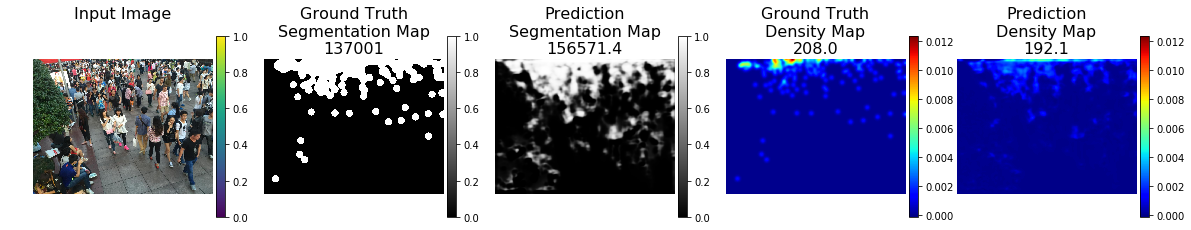

Epoch 1/1
 - 1s - loss: 0.1811 - activation_1_loss: 0.1733 - conv2d_12_loss: 0.1844
Epoch 1/1
 - 1s - loss: 0.1785 - activation_1_loss: 0.1670 - conv2d_12_loss: 0.1834
Epoch 1/1
 - 1s - loss: 0.1738 - activation_1_loss: 0.1641 - conv2d_12_loss: 0.1780
Epoch 1/1
 - 1s - loss: 0.1766 - activation_1_loss: 0.1631 - conv2d_12_loss: 0.1824
Epoch 1/1
 - 1s - loss: 0.1675 - activation_1_loss: 0.1577 - conv2d_12_loss: 0.1717
Epoch 1/1
 - 1s - loss: 0.1687 - activation_1_loss: 0.1578 - conv2d_12_loss: 0.1734
Epoch 1/1
 - 1s - loss: 0.1666 - activation_1_loss: 0.1584 - conv2d_12_loss: 0.1701
Epoch 1/1
 - 1s - loss: 0.1595 - activation_1_loss: 0.1499 - conv2d_12_loss: 0.1636
Epoch 1/1
 - 1s - loss: 0.1576 - activation_1_loss: 0.1479 - conv2d_12_loss: 0.1618
Epoch 1/1
 - 1s - loss: 0.1596 - activation_1_loss: 0.1498 - conv2d_12_loss: 0.1639
Epoch 1/1
 - 1s - loss: 0.1652 - activation_1_loss: 0.1578 - conv2d_12_loss: 0.1684
Epoch 1/1
 - 1s - loss: 0.1623 - activation_1_loss: 0.1510 - conv2d_12_loss:

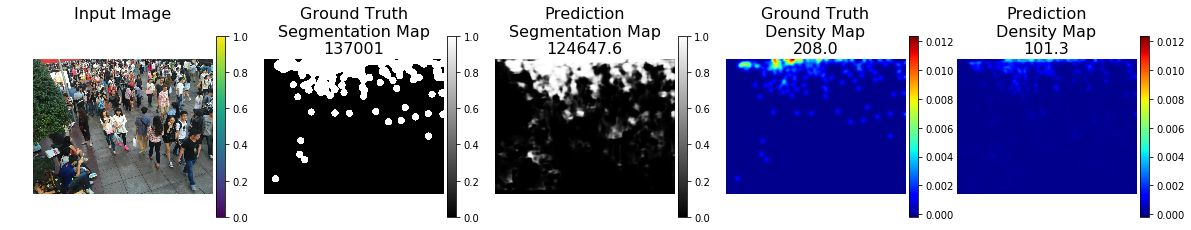

In [11]:
for i in range(100):
    model.fit(x, y, verbose=2)
    pred1, pred2 = model.predict(x)
    if (i + 1) % 20 == 0:
        print(f'Epoch {i+1:2d}:')
        plot_seg_reg_maps(img, gt_seg_map, pred1, gt_density_map, pred2, MULT_FACTOR)